In [1]:
!pip install -q gwpy

In [2]:
%%capture
!pip install matplotlib
!pip install datasets
!pip install transformers
!pip install sklearn
!pip install git+https://github.com/ernlavr/OpenAttack.git
!pip install nltk
!pip install pytorch-crf
!pip install language-tool-python
!pip install "tensorflow>=2.0.0"
!pip install --upgrade tensorflow-hub

In [3]:
%%capture
%reload_ext autoreload
%autoreload 2
%matplotlib inline
import OpenAttack
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import numpy as np
import datasets
import transformers
import torch
import random
from importlib import reload
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

def enforce_reproducibility(seed=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    random.seed(seed)
    np.random.seed(seed)
enforce_reproducibility()

In [4]:
def dataset_mapping(x):
    premise = x['premise']
    hypothesis = x['hypothesis']
    label = x['label']  
    return {
        "x": premise + " " + hypothesis,
        "y": label,
    }

def getLabels():
    return {"SUPPORTS": 0, "NOT ENOUGH INFO": 1, "REFUTES": 2}

def balance_dataset(ds, numSamples=-1):
    """
    Balances the dataset by removing samples
    :param ds: The dataset
    :param numSamples: The number of samples to keep per label
    :return: The balanced indices
    """
    # Get the number of samples for each label
    dss = ds[:]
    labels = dss["fever_gold_label"]
    if numSamples == -1:
        numSamples = len(labels)
        unique, counts = np.unique(labels, return_counts=True)
        counts = np.roll(counts, 1)
        unique = np.roll(unique, 1)
        numSamples = min(counts)

    # get indices of ds elements where ds['label'] is 0
    arr = dss['label']
    arr = np.array(arr)
    indicesSup = np.where(arr == 0)[0][:numSamples]
    indicesNei = np.where(arr == 1)[0][:numSamples]
    indicesRef = np.where(arr == 2)[0][:numSamples]

    # combine the indices
    indices = np.sort((np.concatenate((indicesSup, indicesNei, indicesRef))))
    indices = indices.tolist()
    # get a subset of the dataset
    return indices

print("New Attacker")
print("Build model")
HG_MODEL_NAME = "ernlavr/destilbert_uncased_fever_nli"
HG_DATASET = "pietrolesci/nli_fever"

New Attacker
Build model


In [5]:
%%capture

# Load model, tokenizer and create an OpenAttack classifier
tokenizer = transformers.AutoTokenizer.from_pretrained(HG_MODEL_NAME)
model = transformers.AutoModelForSequenceClassification.from_pretrained(HG_MODEL_NAME, output_hidden_states=True)
clsf = OpenAttack.classifiers.TransformersClassifier(model, tokenizer=tokenizer, embedding_layer=model.base_model.embeddings.word_embeddings)

In [12]:
%%capture
# Load, map and balance the dataset as per fine-tuning
ds = datasets.load_dataset(HG_DATASET)
dataset = ds['dev'].map(function=dataset_mapping)
dsIndices = balance_dataset(dataset, 450)
devSet = torch.utils.data.Subset(dataset, dsIndices)

In [13]:
# Proceed to attacking (rawr)
print("Initialize some mad hacks")
attacker = OpenAttack.attackers.TextFoolerAttacker()

Initialize some mad hacks


In [14]:
print("Start some mad hacks")
attack_eval = OpenAttack.AttackEval(attacker, clsf, metrics=[
    OpenAttack.metric.Fluency(),
    OpenAttack.metric.GrammaticalErrors(),
    OpenAttack.metric.EditDistance(),
    OpenAttack.metric.ModificationRate()
] )
summary, labels = attack_eval.eval(devSet, visualize=True)
preds = labels[0]
gt = labels[1]

Start some mad hacks
Sample: 1 =====================================================================
Label: 2 (74.80%) --> 1 (90.42%)            |                                   
                                            |                                   
Colin Kaepernick became a starting          |                                   
colin kaepernick became a starting          |                                   
                                            |                                   
quarterback during the 49ers 63rd season in |                                   
signal      during the 49ers 63rd season in |                                   
                                            |                                   
the National Football League . Colin        |                                   
the national football league . colin        |                                   
                                            |                                   
Kaeperni

ERROR:OpenAttack.AttackEval:Exception when evaluate data {'cid': 24684, 'fid': 'af2955ff-8e43-4727-b02a-698ef89a3a70', 'premise': 'Arizona is a state in the United States.', 'hypothesis': "Arizona ( [ ɛərᵻˈzoʊnə , _ ærᵻ - ] ) ( Hoozdo Hahoodzo [ xòːztò xɑ̀xòːtsò ] O'odham : Alĭ ṣonak [ ˡaɺi ˡʃonak ] ) is a state in the southwestern region of the United States . It is the sixth largest and the 14th most populous of the 50 states . Arizona is the 48th state and last of the contiguous states to be admitted to the Union , achieving statehood on February 14 , 1912 . About one-quarter of the state is made up of Indian reservations that serve as the home of 27 federally recognized Native American tribes , including the Navajo Nation , the largest in the state and the United States , with more than 300,000 citizens . Arizona , a state in the southwestern region of the United States of America , is known for its high population of Native Americans .", 'verifiable': None, 'fever_gold_label

Sample: 132 ===================================================================
Label: 0 (99.03%) --> Failed!               |                                   
                                            |                                   
Arizona is a state in the United States .   |                                   
Arizona ( [ ɛərᵻˈzoʊnə , _ ærᵻ - ] ) (       |                                   
Hoozdo Hahoodzo [ xo ̀ ːzto ̀ xɑ ̀ xo ̀ ːtso ̀ ] O |                                   
' odham : Ali ̆ s ̣ onak [ ˡaɺi ˡʃonak ] ) is a |                                   
state in the southwestern region of the     |                                   
United States . It is the sixth largest and |                                   
the 14th most populous of the 50 states .   |                                   
Arizona is the 48th state and last of the   | Running Time:            0.017479 
contiguous states to be admitted to the     | Query Exceeded:          no       
Union , achieving

ERROR:OpenAttack.AttackEval:Exception when evaluate data {'cid': 144723, 'fid': 'ffab4700-c8ed-43f4-a4d7-b6d083630f9b', 'premise': 'Part of the Hindu Kush is in Brazil.', 'hypothesis': 'The 2005 Hindu Kush earthquake hit northeastern Afghanistan with a magnitude of 6.5 on December 12 at 21:47 ( UTC ) . The Hindu Kush ( [ kʊʃ , _ kuːʃ ] Pashto , Persian and [ ) , also known in Ancient Greek as the Caucasus Indicus or Paropamisadae , is an 800 km mountain range that stretches near the Afghan-Pakistan border , from central Afghanistan to northern Pakistan . The Hindu Kush range has numerous high snow-capped peaks , with the highest point in the Hindu Kush being Tirich Mir or Terichmir at 7708 m in the Chitral District of Khyber Pakhtunkhwa , Pakistan .', 'verifiable': None, 'fever_gold_label': 'REFUTES', 'label': 2, 'x': 'Part of the Hindu Kush is in Brazil. The 2005 Hindu Kush earthquake hit northeastern Afghanistan with a magnitude of 6.5 on December 12 at 21:47 ( UTC ) . The Hindu Kush

Streaming output truncated to the last 5000 lines.
crystal kay , and girls ' generation and    | Levenshtein Edit Dista:  19       
                                            | Word Modif. Rate:        0.43182  
has also been performed on Glee , The X -   | Succeed:                 yes      
has also been performed on glee , the x -   |                                   
                                            |                                   
Factor , and Britain ' s Got Talent .       |                                   
factor , and britain ' s got talent .       |                                   
                                            |                                   
Sample: 524 ===================================================================
Label: 0 (99.50%) --> 1 (61.42%)            |                                   
                                            | Running Time:            0.22698  
Don Hall is a film writer . Don Hall        | Query Exceede

ERROR:OpenAttack.AttackEval:Exception when evaluate data {'cid': 26675, 'fid': 'e4246586-6497-4446-a0b6-2ede58861d74', 'premise': 'Tottenham Hotspur F.C. was the first British club to win a UEFA club competition.', 'hypothesis': "Tottenham Hotspur F.C. is an English football club based in Tottenham , London . Tottenham Hotspur Football Club [ ˈtɒtnəm , _ - tənəm ] , commonly referred to as Spurs , is an English football club located in Tottenham , Haringey , London , that competes in the Premier League . After successfully defending the FA Cup in 1962 , in 1963 they became the first British club to win a UEFA club competition -- the European Cup Winners ' Cup . In the 1970s Tottenham won the League Cup on two occasions and were the inaugural winner of the UEFA Cup in 1972 , becoming the first British club to win two different major European trophies .", 'verifiable': None, 'fever_gold_label': 'SUPPORTS', 'label': 0, 'x': "Tottenham Hotspur F.C. was the first British club to win a UEFA 

Sample: 712 ===================================================================
Label: 0 (93.86%) --> Failed!               |                                   
                                            |                                   
Tottenham Hotspur F . C . was the first     |                                   
British club to win a UEFA club competition |                                   
. Tottenham Hotspur F . C . is an English   |                                   
football club based in Tottenham , London . |                                   
Tottenham Hotspur Football Club [ ˈtɒtnəm ,  |                                   
_ - tənəm ] , commonly referred to as Spurs |                                   
, is an English football club located in    | Running Time:            0.012093 
Tottenham , Haringey , London , that        | Query Exceeded:          no       
competes in the Premier League . After      | Victim Model Queries:    142      
successfully defending the F

ERROR:OpenAttack.AttackEval:Exception when evaluate data {'cid': 74276, 'fid': 'c66072e0-f3a2-4cea-b5d9-5152d745ba5d', 'premise': 'The Hindu Kush is a valley.', 'hypothesis': 'The Hindu Kush ( [ kʊʃ , _ kuːʃ ] Pashto , Persian and [ ) , also known in Ancient Greek as the Caucasus Indicus or Paropamisadae , is an 800 km mountain range that stretches near the Afghan-Pakistan border , from central Afghanistan to northern Pakistan . It divides the valley of the Amu Darya ( the ancient Oxus ) to the north from the Indus River valley to the south .', 'verifiable': None, 'fever_gold_label': 'REFUTES', 'label': 2, 'x': 'The Hindu Kush is a valley. The Hindu Kush ( [ kʊʃ , _ kuːʃ ] Pashto , Persian and [ ) , also known in Ancient Greek as the Caucasus Indicus or Paropamisadae , is an 800 km mountain range that stretches near the Afghan-Pakistan border , from central Afghanistan to northern Pakistan . It divides the valley of the Amu Darya ( the ancient Oxus ) to the north from the Indus River v

Streaming output truncated to the last 5000 lines.
name dj quik , is an american hip hop       |                                   
                                            |                                   
recording artist , DJ and record producer . |                                   
recording artist , dj and record producer . |                                   
                                            |                                   
Sample: 876 ===================================================================
Label: 2 (99.26%) --> Failed!               |                                   
                                            |                                   
Dakota Fanning is not a model . Hannah      |                                   
Dakota Fanning ( born February 23 , 1994 )  |                                   
is an American actress and model . Her      | Running Time:            1.311    
debut in modeling came in 2009 when she     | Query Exceede

ERROR:OpenAttack.AttackEval:Exception when evaluate data {'cid': 224379, 'fid': '88eb1280-fe44-4327-9c11-92b2d787ac86', 'premise': 'Southampton F.C. is a polo club.', 'hypothesis': "Southampton Football Club [ saʊθˈæmptən , _ - hæmptən ] is a professional association football club based in Southampton , Hampshire , England , which plays in the Premier League , the top tier of English football . The club has been nicknamed `` The Saints '' since its inception in 1885 due to its history as a church football team , founded as St. Mary 's Church of England Young Men 's Association , and play in red and white shirts . Southampton were relegated from the Premier League on 15 May 2005 , ending 27 successive seasons of top-division football for the club .", 'verifiable': None, 'fever_gold_label': 'REFUTES', 'label': 2, 'x': "Southampton F.C. is a polo club. Southampton Football Club [ saʊθˈæmptən , _ - hæmptən ] is a professional association football club based in Southampton , Hampshire , Eng

Streaming output truncated to the last 5000 lines.
characteristic of bluegrass music .         |                                   
                                            |                                   
Sample: 1078 ==================================================================
Label: 0 (77.46%) --> 1 (93.59%)            |                                   
                                            |                                   
Steve Wozniak built the Apple II . The      |                                   
steve wozniak built the malus ii . the      |                                   
                                            |                                   
Apple II is an 8 - bit home computer , one  |                                   
apple ii is an 8 - bit home computer , one  |                                   
                                            |                                   
of the first highly successful mass -       |              

ERROR:OpenAttack.AttackEval:Exception when evaluate data {'cid': 157492, 'fid': '8b7ebc7c-44a1-4ddb-bdd4-9ccb221c69c9', 'premise': 'Arizona is not a state.', 'hypothesis': "Arizona ( [ ɛərᵻˈzoʊnə , _ ærᵻ - ] ) ( Hoozdo Hahoodzo [ xòːztò xɑ̀xòːtsò ] O'odham : Alĭ ṣonak [ ˡaɺi ˡʃonak ] ) is a state in the southwestern region of the United States . It is the sixth largest and the 14th most populous of the 50 states . Arizona is one of the Four Corners states . Arizona is the 48th state and last of the contiguous states to be admitted to the Union , achieving statehood on February 14 , 1912 . About one-quarter of the state is made up of Indian reservations that serve as the home of 27 federally recognized Native American tribes , including the Navajo Nation , the largest in the state and the United States , with more than 300,000 citizens .", 'verifiable': None, 'fever_gold_label': 'REFUTES', 'label': 2, 'x': "Arizona is not a state. Arizona ( [ ɛərᵻˈzoʊnə , _ ærᵻ - ] ) ( Hoozdo Haho

Sample: 1268 ==================================================================
Label: 2 (98.76%) --> Failed!               |                                   
                                            |                                   
Arizona is not a state . Arizona ( [        |                                   
ɛərᵻˈzoʊnə , _ ærᵻ - ] ) ( Hoozdo Hahoodzo [ |                                   
xo ̀ ːzto ̀ xɑ ̀ xo ̀ ːtso ̀ ] O ' odham : Ali ̆ s ̣ |                                   
onak [ ˡaɺi ˡʃonak ] ) is a state in the      |                                   
southwestern region of the United States .  |                                   
It is the sixth largest and the 14th most   |                                   
populous of the 50 states . Arizona is one  | Running Time:            0.013454 
of the Four Corners states . Arizona is the | Query Exceeded:          no       
48th state and last of the contiguous       | Victim Model Queries:    158      
states to be admi

ERROR:OpenAttack.AttackEval:Exception when evaluate data {'cid': 141474, 'fid': 'a680ff8c-d424-46e3-8b8d-77d56b038022', 'premise': 'Arizona is a constituent political entity.', 'hypothesis': "Arizona ( [ ɛərᵻˈzoʊnə , _ ærᵻ - ] ) ( Hoozdo Hahoodzo [ xòːztò xɑ̀xòːtsò ] O'odham : Alĭ ṣonak [ ˡaɺi ˡʃonak ] ) is a state in the southwestern region of the United States . Arizona is one of the Four Corners states . Arizona is the 48th state and last of the contiguous states to be admitted to the Union , achieving statehood on February 14 , 1912 . Exclusive federal powers are powers within a federal system of government that each constituent political unit ( such as a state or province ) is absolutely or conditionally prohibited from exercising . A U.S. state is a constituent political entity of the United States of America .", 'verifiable': None, 'fever_gold_label': 'NOT ENOUGH INFO', 'label': 1, 'x': "Arizona is a constituent political entity. Arizona ( [ ɛərᵻˈzoʊnə , _ ærᵻ - ] ) ( Hooz

Sample: 1288 ==================================================================
Label: 0 (92.49%) --> Failed!               |                                   
                                            |                                   
Arizona is a constituent political entity . |                                   
Arizona ( [ ɛərᵻˈzoʊnə , _ ærᵻ - ] ) (       |                                   
Hoozdo Hahoodzo [ xo ̀ ːzto ̀ xɑ ̀ xo ̀ ːtso ̀ ] O |                                   
' odham : Ali ̆ s ̣ onak [ ˡaɺi ˡʃonak ] ) is a |                                   
state in the southwestern region of the     |                                   
United States . Arizona is one of the Four  |                                   
Corners states . Arizona is the 48th state  | Running Time:            0.011884 
and last of the contiguous states to be     | Query Exceeded:          no       
admitted to the Union , achieving statehood | Victim Model Queries:    145      
on February 14 , 

ERROR:OpenAttack.AttackEval:Exception when evaluate data {'cid': 53135, 'fid': '8da40bc4-49f0-4e39-a032-a16866065735', 'premise': 'Arizona is in North America.', 'hypothesis': "Arizona ( [ ɛərᵻˈzoʊnə , _ ærᵻ - ] ) ( Hoozdo Hahoodzo [ xòːztò xɑ̀xòːtsò ] O'odham : Alĭ ṣonak [ ˡaɺi ˡʃonak ] ) is a state in the southwestern region of the United States . It is also part of the Western and the Mountain states . It is the sixth largest and the 14th most populous of the 50 states . Arizona 's border with Mexico is 389 miles ( 626 km ) long , on the northern border of the Mexican states of Sonora and Baja California . About one-quarter of the state is made up of Indian reservations that serve as the home of 27 federally recognized Native American tribes , including the Navajo Nation , the largest in the state and the United States , with more than 300,000 citizens .", 'verifiable': None, 'fever_gold_label': 'SUPPORTS', 'label': 0, 'x': "Arizona is in North America. Arizona ( [ ɛərᵻˈzoʊnə 

Sample: 1312 ==================================================================
Label: 2 (99.06%) --> Failed!               |                                   
                                            |                                   
Arizona is in North America . Arizona ( [   |                                   
ɛərᵻˈzoʊnə , _ ærᵻ - ] ) ( Hoozdo Hahoodzo [ |                                   
xo ̀ ːzto ̀ xɑ ̀ xo ̀ ːtso ̀ ] O ' odham : Ali ̆ s ̣ |                                   
onak [ ˡaɺi ˡʃonak ] ) is a state in the      |                                   
southwestern region of the United States .  |                                   
It is also part of the Western and the      |                                   
Mountain states . It is the sixth largest   | Running Time:            0.011638 
and the 14th most populous of the 50 states | Query Exceeded:          no       
. Arizona ' s border with Mexico is 389     | Victim Model Queries:    164      
miles ( 626 km ) 

In [15]:
print(classification_report(gt, preds))

              precision    recall  f1-score   support

           0       0.11      0.04      0.06       500
           1       0.27      0.52      0.35       473
           2       0.28      0.20      0.23       377

    accuracy                           0.25      1350
   macro avg       0.22      0.25      0.22      1350
weighted avg       0.22      0.25      0.21      1350



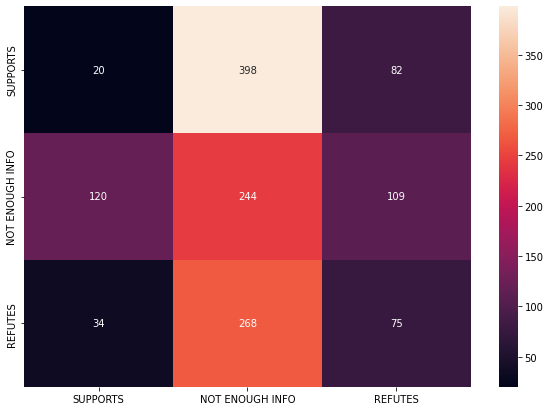

In [16]:
cm = confusion_matrix(gt, preds)
classes = [*getLabels()]
df_cfm = pd.DataFrame(cm, index = classes, columns = classes)
plt.figure(figsize = (10,7))
cfm_plot = sn.heatmap(df_cfm, annot=True, fmt='g')